In [1]:
!pip install transformers
!pip install wget

     |████████████████████████████████| 2.3MB 8.5MB/s 
     |████████████████████████████████| 901kB 52.4MB/s 
     |████████████████████████████████| 3.3MB 39.1MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=ac7cb4715473dd4ebcf14c2beac37aacabdc7074dbedfb4ab418858384a5f2cc
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [54]:
# Datenvorbereitung
import json
import wget

# download and open json file
url = 'https://raw.githubusercontent.com/Johannes96/BERT_fineTune/master/data/final_train_asc_CLS.json'
dataset1 = wget.download(url)

with open(dataset1) as json_file:
    train_asc = json.load(json_file)

url = 'https://raw.githubusercontent.com/Johannes96/BERT_fineTune/master/data/final_dev_asc_CLS.json'
dataset2 = wget.download(url)

with open(dataset2) as json_file:
    dev_asc = json.load(json_file)

# Extrahiere sentences und labels aus den Daten
train_texts = []
train_labels_temp = []
for i in train_asc:
    train_labels_temp.append(train_asc[i]['polarity'])
    train_texts.append(train_asc[i]['sentence'])

dev_texts = []
dev_labels_temp = []
for i in dev_asc:
    dev_labels_temp.append(dev_asc[i]['polarity'])
    dev_texts.append(dev_asc[i]['sentence'])

# Ersetzte labels durch Nummern von 0 bis 4
train_labels = []
for i in train_labels_temp:
    if i == 'str_negative':
        train_labels.append(0)
    elif i == 'negative':
        train_labels.append(1)
    elif i == 'neutral':
        train_labels.append(2)
    elif i == 'positive':
        train_labels.append(3)
    elif i == 'str_positive':
        train_labels.append(4)

dev_labels = []
for i in dev_labels_temp:
    if i == 'str_negative':
        dev_labels.append(0)
    elif i == 'negative':
        dev_labels.append(1)
    elif i == 'neutral':
        dev_labels.append(2)
    elif i == 'positive':
        dev_labels.append(3)
    elif i == 'str_positive':
        dev_labels.append(4)

# Verreinige Listen zu einem Datensatz
texts = train_texts
labels = train_labels
labels.extend(dev_labels)
texts.extend(dev_texts)

# Teile in Trainings- und Testdaten auf
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=.2)


In [55]:
# Load Tokenizer
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenizing der Trainings- und Testdaten
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# erstelle Datensätze
import torch

class ASCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ASCDataset(train_encodings, train_labels)
val_dataset = ASCDataset(val_encodings, val_labels)
# test_dataset = ASCDataset(test_encodings, dev_labels)

# Anpassung von BERT sodass er mit 5 labels funktioniert
from transformers import BertForSequenceClassification, BertConfig, Trainer, TrainingArguments
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 5 # adjust to change number of distinct labels (y)
model = BertForSequenceClassification(config)
# print(model.parameters) # show how many labels (out_features = ___) are defined

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=8,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [56]:
# Trainingsphase
trainer.train()

Step,Training Loss
10,1.604300
20,1.521100
30,1.397700
40,1.423800
50,1.448100
60,1.473100
70,1.448600
80,1.466600
90,1.506300
100,1.432600


TrainOutput(global_step=3672, training_loss=0.9151238691637978, metrics={'train_runtime': 1463.1053, 'train_samples_per_second': 2.51, 'total_flos': 196552704374550.0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 438819328, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -1160855552, 'train_mem_gpu_alloc_delta': 1322890752, 'train_mem_cpu_peaked_delta': 1165185024, 'train_mem_gpu_peaked_delta': 1483566592})

In [ ]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_loss': 1.1476783752441406,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 401538560,
 'eval_runtime': 12.0564,
 'eval_samples_per_second': 152.201}

In [6]:
import datetime
print(str(datetime.timedelta(seconds=176)))

0:02:56


In [51]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d9666490-462c-0ba1-565c-a037f67470e4)


In [57]:
import numpy as np

text1 = val_texts
label1 = val_labels
tokenized_texts = tokenizer(text1, truncation=True, padding=True)

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

test_dataset = SimpleDataset(tokenized_texts)
predictions = trainer.predict(test_dataset)

# Erstelle Liste mit prognostizierten Labels
pred_labels = []
for i, pred in enumerate(predictions.predictions):
  pred_labels.append(np.where(pred == np.amax(pred))[0][0])

In [58]:
# Berechne Metriken MSE, Confusion-Martix und F1-Score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

mse = mean_squared_error(val_labels, pred_labels)
accuracy = accuracy_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels, average='macro') # zu klären welcher average-Wert verwendet werden soll
conf_matrix = confusion_matrix(val_labels, pred_labels)

print('MSE:', mse)
print('Accuracy:', accuracy)
print('F1-Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

MSE: 1.1771117166212535
Accuracy: 0.5634877384196185
F1-Score: 0.4710526492316179
Confusion Matrix:
 [[ 53  58   4  26  13]
 [ 33 162  13  69  18]
 [  6  29  17  38  14]
 [ 10  63  20 352 180]
 [  6  21   2 178 450]]


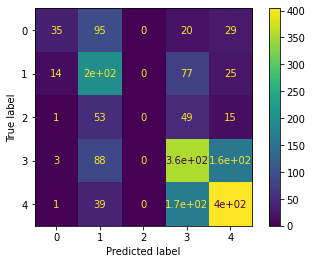

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
lab = [0,1,2,3,4]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lab)
disp.plot()

In [ ]:
# Erstelle json mit allen zur Evaluation relevanten Werten
import json

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

# Manuell die Werte für Trainingszeit/Evaluationszeit (Format: min.sek), Trainingsloss und Evaluationloss mauell einfügen 
eval_values = {'train_runtime': 8.55, 'evaluation_runtime': 0.11, 'Trainingsloss': 1.2040496734752115, 
               'Evaluationloss': 1.1476783752441406, 'mse': mse, 'accuracy': accuracy, 'confusion_matrix': conf_matrix.tolist(), 
               'f1_score': f1, 'sentences': val_texts, 'actual_labels': val_labels, 'predicted_labels': pred_labels}

print(eval_values)

with open('eval_asc_BERT.json', 'w') as fp:
    json.dump(eval_values, fp, default=np_encoder)

{'train_runtime': 8.55, 'evaluation_runtime': 0.11, 'Trainingsloss': 1.2040496734752115, 'Evaluationloss': 1.1476783752441406, 'mse': 1.3787465940054495, 'accuracy': 0.5416893732970027, 'confusion_matrix': [[35, 95, 0, 20, 29], [14, 200, 0, 77, 25], [1, 53, 0, 49, 15], [3, 88, 0, 355, 162], [1, 39, 0, 170, 404]], 'f1_score': 0.40163138165385204, 'sentences': ['His smile alone made me want to come back in the future .', 'Amazing vegan cookies .', 'Great music and atmosphere .', 'The standout was a cooked black cod , amazingly tender and unbelievably delicious .', 'This place has a nice authentic feel and I imagined myself in Hong Kong .', "Let ' s start at the top , the service is brutal !", 'My friends ordered different curries and one said the green curry was the best he ever had .', 'But the location more than compensated , so in the end it was a most enjoyable evening .', 'Huge variety of sandwiches and wraps ( or you can create your own ), make your own salads , really good soups a